# Pattern Lakehouse
Sujet de stage 2023

In [125]:
! pip freeze > requirements/requirements.txt

In [126]:
! pip install -r requirements/requirements.txt

Processing c:\ci\anyio_1644463701441\work\dist (from -r requirements/requirements.txt (line 1))


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\ci\\anyio_1644463701441\\work\\dist'



In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from imblearn.over_sampling import SMOTE
import opendatasets as od
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from snowflake.snowpark import version
from snowflake.snowpark.functions import udf, sproc, col
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import IntegerType, FloatType, StringType, BooleanType, Variant

print(f"Snowflake snowpark version is: {version.VERSION}")



Snowflake snowpark version is: (1, 3, 0)


In [128]:
# # Gets the version
# ctx = snowflake.connector.connect(
#     user='maxellende',
#     password='passwordSF22!',
#     account='GVQJSJC-MP40342', 
#     role = 'ACCOUNTADMIN',
#     warehouse = 'HOL_WH',
#     schema = 'PUBLIC',
#     database = 'HOL_DB'

#     )



In [131]:
with open('creds.json') as f:
    connection_parameters = json.load(f)
session = Session.builder.configs(connection_parameters).create()
print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "HOL_DB"."PUBLIC"
Current Warehouse: "HOL_WH"


In [132]:
df = session.table('CREDIT_RECORD')
df.show()

df.describe().to_pandas()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

,SUMMARY,FRAUD_BOOL,INCOME,NAME_EMAIL_SIMILARITY,PREV_ADDRESS_MONTHS_COUNT,CURRENT_ADDRESS_MONTHS_COUNT,CUSTOMER_AGE,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,ZIP_COUNT_4W,...,HOUSING_STATUS_BA,HOUSING_STATUS_BC,HOUSING_STATUS_BD,SOURCE_INTERNET,SOURCE_TELEAPP,DEVICE_OS_LINUX,DEVICE_OS_X11,DEVICE_OS_WINDOWS,DEVICE_OS_MACINTOSH,DEVICE_OS_OTHER
0,count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
1,min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,...,0.169675,0.372143,0.026161,0.992952,0.007048,0.332712,0.007228,0.263506,0.053826,0.342728
4,stddev,0.104437,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,...,0.375348,0.483377,0.159615,0.083654,0.083654,0.471185,0.084711,0.440535,0.225675,0.474622


## Model development


In [133]:
X = df.drop("FRAUD_BOOL").to_pandas()
y = df.select("FRAUD_BOOL").to_pandas()
print('ok')




ok


In [134]:
df.to_pandas().select_dtypes(include = 'object')

""
0
1
2
3
4
...
999995
999996
999997
999998


In [143]:
def disp_nan(df) :
    nb_nan = pd.DataFrame()
    for c in df.columns : 
        request = f"SELECT count(*) AS {c} FROM CREDIT_RECORD WHERE {c} IS NULL  \
        UNION ALL \
        SELECT  count(*) AS {c} FROM CREDIT_RECORD WHERE {c} IS NOT NULL ;"
        nb_nan=pd.concat([nb_nan, session.sql(request).to_pandas()], axis =1 )
    nb_nan.index = ['Not NaN', 'NaN']
    return nb_nan

disp_nan(df)


,FRAUD_BOOL,INCOME,NAME_EMAIL_SIMILARITY,PREV_ADDRESS_MONTHS_COUNT,CURRENT_ADDRESS_MONTHS_COUNT,CUSTOMER_AGE,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,ZIP_COUNT_4W,VELOCITY_6H,...,HOUSING_STATUS_BA,HOUSING_STATUS_BC,HOUSING_STATUS_BD,SOURCE_INTERNET,SOURCE_TELEAPP,DEVICE_OS_LINUX,DEVICE_OS_X11,DEVICE_OS_WINDOWS,DEVICE_OS_MACINTOSH,DEVICE_OS_OTHER
Not NaN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
NaN,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,...,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000


c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\numpy\core\fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


Text(0.5, 1.0, 'Repartition of fraud cases in the dataset \n0.011029% fraud')

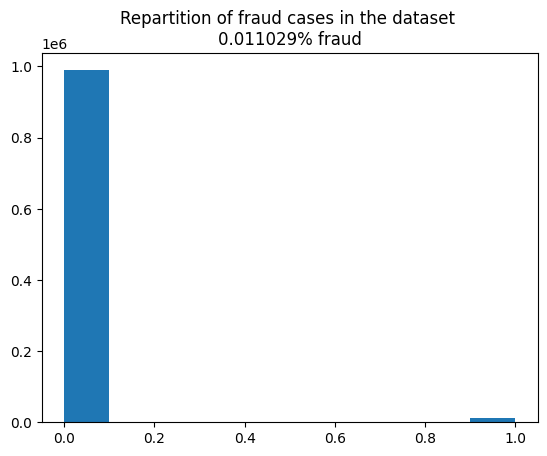

In [144]:
class_weight = {1 : int(np.sum(y)), 0 : len(y) - int(np.sum(y))}
plt.hist(y)
plt.title(f'Repartition of fraud cases in the dataset \n{np.mean(y)[0]}% fraud')

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X,y)
# disp_nan(X_train)

df_pred = pd.concat([X_test, y_test], axis = 1)
print(df_pred)



        INCOME  NAME_EMAIL_SIMILARITY  PREV_ADDRESS_MONTHS_COUNT  \
312955     0.9               0.747407                         -1   
880001     0.7               0.864529                         -1   
859902     0.7               0.712547                         -1   
927801     0.1               0.878431                         -1   
875212     0.1               0.309641                         60   
...        ...                    ...                        ...   
83141      0.9               0.200880                         -1   
745098     0.2               0.711392                         -1   
441491     0.7               0.941061                         -1   
180535     0.9               0.770812                         -1   
265723     0.2               0.502692                         46   

        CURRENT_ADDRESS_MONTHS_COUNT  CUSTOMER_AGE  DAYS_SINCE_REQUEST  \
312955                            85            20            7.437106   
880001                           17

In [146]:
numeric_cols = df.to_pandas().select_dtypes(include=['float64']).columns

scaler = MinMaxScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train

,INCOME,NAME_EMAIL_SIMILARITY,PREV_ADDRESS_MONTHS_COUNT,CURRENT_ADDRESS_MONTHS_COUNT,CUSTOMER_AGE,DAYS_SINCE_REQUEST,INTENDED_BALCON_AMOUNT,ZIP_COUNT_4W,VELOCITY_6H,VELOCITY_24H,...,HOUSING_STATUS_BA,HOUSING_STATUS_BC,HOUSING_STATUS_BD,SOURCE_INTERNET,SOURCE_TELEAPP,DEVICE_OS_LINUX,DEVICE_OS_X11,DEVICE_OS_WINDOWS,DEVICE_OS_MACINTOSH,DEVICE_OS_OTHER
615760,0.750,0.669950,-1,45,50,0.000121,0.110568,1240,0.187163,0.302067,...,0,1,0,0,1,0,0,0,0,1
779451,0.875,0.137876,-1,20,40,0.000665,0.110721,1401,0.065799,0.254454,...,1,0,0,1,0,1,0,0,0,0
477398,0.750,0.088350,-1,145,40,0.000095,0.541383,1261,0.514059,0.611909,...,1,0,0,1,0,0,0,1,0,0
840992,0.125,0.907434,-1,178,40,0.000051,0.114092,809,0.326746,0.287394,...,0,1,0,1,0,0,0,0,0,1
290941,1.000,0.516937,-1,32,30,0.000055,0.116097,1626,0.588829,0.498151,...,0,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252956,0.625,0.372725,-1,224,10,0.000260,0.112792,824,0.199266,0.205522,...,0,0,0,1,0,0,0,0,0,1
214637,0.875,0.845325,54,8,40,0.000181,0.111255,714,0.284449,0.390897,...,0,0,0,1,0,0,0,0,0,1
221844,0.875,0.087528,-1,38,30,0.000494,0.108441,1244,0.177354,0.099579,...,0,1,0,1,0,0,0,0,0,1
862294,0.125,0.512427,-1,90,40,0.000254,0.112266,1491,0.716225,0.572236,...,0,1,0,1,0,0,0,0,0,1


In [147]:
from sklearn.decomposition import PCA
n_before = X_train.shape[1]
pca = PCA(n_components=0.99)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(f"Before PCA : {n_before} components \nAfter PCA : {pca.n_components_} components, explained variance : 0.9")
print("Explained variances : ", pca.explained_variance_ratio_)


Before PCA : 52 components 
After PCA : 3 components, explained variance : 0.9
Explained variances :  [0.81741345 0.17058649 0.00653756]


In [148]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [153]:
def score_classifier(estimator,parameters, X_train, y_train, X_test, y_test):

    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    # search for best parameters
    cv = StratifiedKFold(n_splits = 5, shuffle = True).split(X_train,y_train)
    clf = GridSearchCV(estimator, parameters, scoring ='recall', verbose =1, cv = cv)
    clf.fit(X_train,y_train)

    # evaluate best estimator
    best_estimator = clf.best_estimator_
    parameters = clf.best_params_
    score = clf.best_score_
    print(f'Average score of the best estimator : {score}')
    y_pred = clf.predict(X_test) # same as best_estimator.predict(X)
    cm = confusion_matrix(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()
    title = str(estimator)+'\n f1-score on test dataset : '+str(f1)
    plt.title(title)
    plt.show()
    return(best_estimator, parameters, y_pred, score, cm)

In [150]:
# To have the correct data types, we initialize the table
estimator = LogisticRegression(verbose = 1)
estimator.fit(X_train,y_train)
y_pred = estimator.predict(X_test)
score = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test,y_pred)
parameters = estimator.get_params()

session.write_pandas(df_pred, table_name='PREDICTIONS', auto_create_table=True, overwrite=True)
df_pred = session.table('PREDICTIONS')
df_pred.show()

df_score = pd.DataFrame(columns = ['estimator', 'parameters', 'score', 'tp', 'fp', 'fn', 'tn'])
name = str(estimator)[:-11]
row = [name, str(parameters), score, cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
df_score.loc[0] = row

session.write_pandas(df_score, table_name='SCORES', auto_create_table=True, overwrite=True)
df_score = session.table('SCORES')

def uppercase_all_columns(df: snowflake.snowpark.DataFrame) -> snowflake.snowpark.DataFrame:
    return df.select([F.col(column).as_(column.upper()) for column in df.columns])
df_score = uppercase_all_columns(df_score)
df_score.write.save_as_table(table_name='SCORES', mode='overwrite')

df_score = session.table('SCORES')
df_score.show()



c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\snowflake\snowpark\session.py:1346: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

c:\Users\maxellende.julienne\Anaconda3\envs\env_stage\lib\site-packages\snowflake\snowpark\session.py:1346: UserWarning: Pandas Dataframe has non-standard index of type <class 'pandas.core.indexes.numeric.Int64Index'> which will not be written. Consider changing the index to pd.RangeIndex(start=0,...,step=1) or call reset_index() to keep index as column(s)
  success, nchunks, nrows, ci_output = write_pandas(


---------------------------------------------------------------------------------------------------------------------------------
|"ESTIMATOR"         |"PARAMETERS"                                        |"SCORE"               |"TP"   |"FP"    |"FN"  |"TN"  |
---------------------------------------------------------------------------------------------------------------------------------
|LogisticRegression  |{'C': 1.0, 'class_weight': None, 'dual': False,...  |0.022761455931013735  |92248  |154952  |984   |1816  |
---------------------------------------------------------------------------------------------------------------------------------



In [151]:
from snowflake.snowpark.functions import lit
from snowflake.snowpark import Row, Column
def save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm):
    name = str(estimator)[:-2]
    session.sql("ALTER TABLE PREDICTIONS ADD COLUMN IF NOT EXISTS {} float(20)".format(name)).collect()
    df_pred = session.table('PREDICTIONS')


    row = [name, str(parameters), float(str(score)), cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
    df_score =df_score.to_pandas()
    df_score.loc[len(df_score)] = row
    print(df_score)
    session.write_pandas(df_score, table_name='SCORES', auto_create_table=True, overwrite=True)

In [154]:
estimator = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty: L1 or L2
    'C': [0.1, 1, 10],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Solver algorithm: 'liblinear' for small datasets, 'saga' for large datasets
}
best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)


save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [ ]:
param_grid = {
    'n_estimators': [10, 100],  # Number of trees in the random forest
    'max_depth': [5, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': [0.90, 'sqrt'],  # Number of features to consider when looking for the best split
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}
estimator = RandomForestClassifier()
best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)


save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)




    


# y = y.values.ravel()


In [ ]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMClassifier()

param_grid = {
    'boosting_type': ['gbdt', 'dart'],  # Boosting type: Gradient Boosting Decision Tree (gbdt) or Dart
    'num_leaves': [31, 63, 127],  # Maximum number of leaves in one tree
    'learning_rate': [1.0, 0.1, 0.01],  # Learning rate
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0.0, 0.1, 0.5],  # L1 regularization term
    'reg_lambda': [0.0, 0.1, 0.5]  # L2 regularization term
}

best_estimator, parameters, y_pred, score, cm = score_classifier(estimator,param_grid, X_train, y_train, X_test, y_test)
save_results(df_pred, df_score, estimator, parameters, y_pred, score, cm)